In [2]:
from notebook_utils import load_tinymodel, load_tinydataset, load_saes
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/root/dictionary_learning/circuits/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/dictionary_learning/circuits/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
llm = load_tinymodel()
dataset = load_tinydataset(batch_size=1, max_seq_length=128, num_datapoints=10000, to_dataloader=False)
all_saes = load_saes(k=30)

100%|██████████| 10000/10000 [00:18<00:00, 543.71it/s]


Failed to tokenize 0 tokens
Number of datapoints w/ 129 tokens: 9473
Total Tokens: 1.222017M


/root/dictionary_learning/notebooks/notebook_utils.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


# Gradient but only on each batch, no accumulation
Accumulating gradients over batches != gradient over a large batch
We also can't backpropogate through the computation graph over the accumulated normalized sum because the computation graph doesn't exist, lol. 

There still might be a way to calculate gradient correctly (w/ a custom grad-function), but I'm intentionally making that out of scope.


In [4]:
from einops import rearrange, einsum
from tqdm import tqdm
from torch.utils.data import DataLoader

target_sae_names = ['torso_1_mlp_out_transcoder', 'torso_1_res_final']
saes = [all_saes[name].to(device) for name in target_sae_names]
num_input_features = saes[0].encoder.weight.shape[0]
num_output_features = saes[1].encoder.weight.shape[0]


resid_mid = llm.torso[1].res_mlp
resid_final = llm.torso[1].res_final
mlp_out = llm.torso[1].mlp

entropy_across_batches = []
transcoder = saes[0].to(device)
sae_final = saes[1].to(device)

tr_dec = transcoder.decoder.weight
final_enc = sae_final.encoder.weight
optimizer = torch.optim.Adam(list(transcoder.parameters()) + list(sae_final.parameters()), lr=1e-3)
grads_t_dec = []
grads_t_enc = []
grads_f_enc = []
current_dataset = None
for batch_size in tqdm(range(0, 500, 50)):
    optimizer.zero_grad()
    loader = DataLoader(dataset, batch_size=batch_size+1, shuffle=True)
    batch_dict = next(iter(loader))
    batch = torch.stack(batch_dict["input_ids"], dim=-1)
    batch = batch.to(device)


    with torch.no_grad(), llm.trace(batch) as tracr:
        act_res_mid = resid_mid.output.save()
        act_res_final = resid_final.output.save()
        act_mlp_out = mlp_out.output.save()

    # Get the input & output activations and indices
    act_res_mid = act_res_mid.detach().to(device)
    act_res_mid = rearrange(act_res_mid, 'b s d_model -> (b s) d_model')

        # Forward pass through SAEs
    with torch.set_grad_enabled(True):
        feature_by_feature_attribution = torch.zeros(num_input_features, num_output_features).to(device)
        running_total_for_each_feature = torch.zeros(num_output_features).to(device)
        virtual_weights = transcoder.decoder.weight.T @ sae_final.encoder.weight.T

        input_features, input_acts, input_indices = transcoder.encode(act_res_mid, return_topk=True)
    
        mlp_out_hat = transcoder.decoder(input_features)

        output_features, output_acts, output_indices = sae_final.encode(mlp_out_hat + act_res_mid, return_topk=True)
        
        # Compute attribution for each input-output pair
        in_idx = input_indices[:, :, None]    # Shape: [batch, k, 1]
        out_idx = output_indices[:, None, :]  # Shape: [batch, 1, k]
        result = virtual_weights[in_idx, out_idx]  # Shape: [batch, k, k]
        attribution = einsum(input_acts, result,'b k_inp, b k_inp k_out-> b k_inp k_out')

        # Initialize full feature matrix
        full_attribution = torch.zeros(virtual_weights.shape, device=attribution.device)

        # Accumulate attributions for each input-output pair
        full_attribution.index_put_(
            (in_idx.expand(-1, -1, attribution.shape[-1]).reshape(-1),
            out_idx.expand(-1, attribution.shape[1], -1).reshape(-1)),
            attribution.reshape(-1),
            accumulate=True
        )
        # Count occurrences of each output index
        counts = torch.zeros(virtual_weights.shape[1], device=output_indices.device)
        counts.index_add_(0, output_indices.reshape(-1), 
                        torch.ones_like(output_indices.reshape(-1), dtype=torch.float))
        pre_clamp_counts = counts.clone()

        # Avoid divide by zero 
        counts = counts.clamp(min=1)

        # Divide output_features by how many times they appear
        full_attribution = full_attribution / counts[None, :]

        EPS = 1e-10
        # Let's only calculate loss over non-zero output features
        alive_output_features = pre_clamp_counts != 0
        pos_avg =  full_attribution[:, alive_output_features].abs()
        normed = pos_avg / (pos_avg.sum(dim=0, keepdim=True))
        # Add small epsilon just to logs, maintains sum-to-1 property
        logged = torch.log(torch.clamp(normed, min=EPS))
        entropy_loss = -(normed * logged).sum(dim=0).mean()

        entropy_loss.backward()
        print(f"num tokens: {batch.shape[0]*batch.shape[1]} | Entropy: {entropy_loss.item()}")
        # print(f"")
        
        # Store gradients
        grads_t_dec.append(transcoder.decoder.weight.grad.clone().cpu())
        grads_t_enc.append(transcoder.encoder.weight.grad.clone().cpu())
        grads_f_enc.append(sae_final.encoder.weight.grad.clone().cpu())
        
        # Optional: check for NaNs
        if any(torch.isnan(grad).any() for grad in [grads_t_dec[-1], grads_t_enc[-1], grads_f_enc[-1]]):
            print("NaN detected in gradients")

 10%|█         | 1/10 [00:01<00:15,  1.71s/it]

num tokens: 129 | Entropy: 2.9938015937805176


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

num tokens: 6579 | Entropy: 4.113683223724365


 30%|███       | 3/10 [00:12<00:32,  4.63s/it]

num tokens: 13029 | Entropy: 4.339517593383789


 40%|████      | 4/10 [00:20<00:36,  6.00s/it]

num tokens: 19479 | Entropy: 4.4546613693237305


 50%|█████     | 5/10 [00:30<00:37,  7.46s/it]

num tokens: 25929 | Entropy: 4.523906707763672


 60%|██████    | 6/10 [00:42<00:35,  8.94s/it]

num tokens: 32379 | Entropy: 4.573797702789307


 70%|███████   | 7/10 [00:54<00:30, 10.13s/it]

num tokens: 38829 | Entropy: 4.61957311630249


 80%|████████  | 8/10 [01:09<00:23, 11.77s/it]

num tokens: 45279 | Entropy: 4.641940116882324


 90%|█████████ | 9/10 [01:26<00:13, 13.31s/it]

num tokens: 51729 | Entropy: 4.663559436798096


100%|██████████| 10/10 [01:45<00:00, 10.56s/it]

num tokens: 58179 | Entropy: 4.681214809417725


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


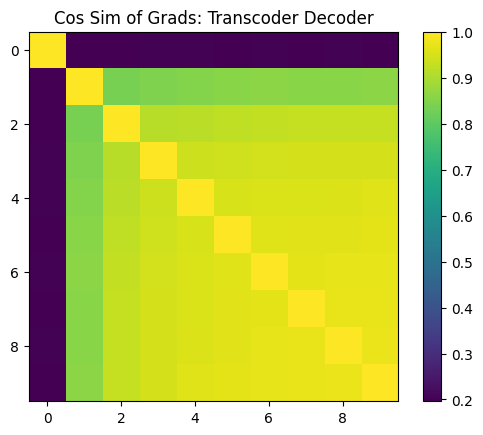

In [5]:
# Compare the L2 MSE error between the gradients in an imshow matrix image
import matplotlib.pyplot as plt
import numpy as np

def gradient_similarity(g1, g2):
    # g1, g2 are rectangular matrices of same shape
    # Flatten matrices into 1D vectors
    g1_flat = g1.reshape(-1)  # or g1.flatten()
    g2_flat = g2.reshape(-1)

    # Compute cosine similarity
    similarity = (g1_flat @ g2_flat) / (np.linalg.norm(g1_flat) * np.linalg.norm(g2_flat))
    return similarity
setting = "t_dec"
# setting = "t_enc"
# setting = "f_enc"
if setting == "t_dec":
    target_grads = torch.stack(grads_t_dec)
    title = "Transcoder Decoder"
elif setting == "t_enc":
    target_grads = torch.stack(grads_t_enc)
    title = "Transcoder Encoder"
elif setting == "f_enc":
    target_grads = torch.stack(grads_f_enc)
    title = "Final Encoder"

# Calculate the L2 MSE error between the gradients
l2_mse_error = torch.zeros(target_grads.shape[0], target_grads.shape[0])
for i in tqdm(range(target_grads.shape[0])):
    for j in range(target_grads.shape[0]):
        # l2_mse_error[i, j] = torch.nn.functional.mse_loss(target_grads[i], target_grads[j])
        l2_mse_error[i, j] = gradient_similarity(target_grads[i], target_grads[j])

plt.imshow(l2_mse_error)
plt.title("Cos Sim of Grads: "+title)
plt.colorbar()
plt.show()

# Just calculate Entropy TODO: unfinished. Need to make more efficient like above

In [14]:
from einops import rearrange, einsum
from tqdm import tqdm

# def update_running_average_with_sum(current_avg, new_sum, current_count, new_count):
#     """
#     Update the running average with a new sum and count.
    
#     :param current_avg: Current running average
#     :param new_sum: Sum of new values to include in the average
#     :param current_count: Number of values in the current average
#     :param new_count: Number of new values
#     :return: New running average, Updated total count
#     """
#     if current_count == 0:
#         return new_sum / new_count, new_count
    
#     total_count = current_count + new_count
#     updated_sum = current_avg * current_count + new_sum
#     updated_avg = updated_sum / total_count
#     return updated_avg, total_count
target_sae_names = ['torso_1_mlp_out_transcoder', 'torso_1_res_final']
saes = [all_saes[name].to(device) for name in target_sae_names]
num_input_features = saes[0].encoder.weight.shape[0]
num_output_features = saes[1].encoder.weight.shape[0]
feature_by_feature_attribution = torch.zeros(num_input_features, num_output_features).to(device)
running_total_for_each_feature = torch.zeros(num_output_features).to(device)

resid_mid = llm.torso[1].res_mlp
resid_final = llm.torso[1].res_final
mlp_out = llm.torso[1].mlp
# for batch_ind, batch in enumerate(dataset):
# add tqdm to enumerate correctly
#
entropy_across_batches = []
# Now we want to run through the saes
transcoder = saes[0].to(device)
sae_final = saes[1].to(device)

# Virtual weights = upstream_decoder @ downstream_encoder [feature, feature]
tr_dec = transcoder.decoder.weight
final_enc = sae_final.encoder.weight
virtual_weights = tr_dec.T @ final_enc.T
# Set an optimizer on both dec and enc
grads_t_dec = []
grads_t_enc = []
grads_f_enc = []
check_grads_every_N = 1
with torch.no_grad():
    for batch_ind, batch in enumerate(tqdm(dataset)):
    

        batch = batch.to(device)
        with torch.no_grad(), llm.trace(batch) as tracr:
            act_res_mid = resid_mid.output.save()
            act_res_final = resid_final.output.save()
            act_mlp_out = mlp_out.output.save()

        # Get the input & output activations and indices
        act_res_mid = act_res_mid.to(device)
        act_res_mid = rearrange(act_res_mid, 'b s d_model -> (b s) d_model')
        input_features, input_acts, input_indices = transcoder.encode(act_res_mid, return_topk=True)
        mlp_out_hat = transcoder.decoder(input_features)

        output_features, output_acts, output_indices = sae_final.encode(mlp_out_hat + act_res_mid, return_topk=True)
        
        new_f_by_f = torch.zeros_like(feature_by_feature_attribution)
        for current_output_feature in range(num_output_features):
            # Get the batch indices where the output feature is non-zero
            # output_indices is [batch, k], so find where k is the current output feature
            # sum over feature/k dim, which is at most 1, since a feature can only be activated once/datapoint
            nz_batch_indices = (output_indices==current_output_feature).sum(-1).nonzero()[:, 0]
            current_output_virtual_weights = virtual_weights[:, current_output_feature]

            # TODO: concern that I'm not adding nz_input_ind into the right slots (it's [batch, k] w/ different values for k which define different index)
            # Index into the virtual weights & input indices ie find the inputs that activated the output feature
            nz_input_ind = input_indices[nz_batch_indices]
            batched_virtual_weights = current_output_virtual_weights[nz_input_ind].to(device)
            nz_input_acts = input_acts[nz_batch_indices]

            # Calculate the attribution ie act*gradient
            current_output_attribution = nz_input_acts * batched_virtual_weights 

            # The new count is the number of non-zero batch indices for this feature
            # We need this to update the average; whether or not the current output feature activates on 1 datapoint or
            # 100 datapoints in this batch will affect the avg.
            new_count = len(nz_batch_indices)

            # Update the total attribution, we'll divide by the total count later
            # Do scatter add to account for duplicated indices (commented out code just gets last value, not summed)
            feature_by_feature_attribution[:, current_output_feature].scatter_add_(
                0, 
                nz_input_ind.flatten(),
                current_output_attribution.flatten(),
            )
            # feature_by_feature_attribution[nz_input_ind, current_output_feature] += current_output_attribution
            running_total_for_each_feature[current_output_feature] += new_count
        if(batch_ind % check_grads_every_N == 0):
            # Now we want to divide feature_by_feature_attribution by each of the times it activated
            alive_output_features = running_total_for_each_feature != 0

            averaged_feature_by_feature_attribution = feature_by_feature_attribution[:, alive_output_features] / running_total_for_each_feature[None, alive_output_features]
            # Now we want to convert to a prob-dist and calculate entropy on it, ignoring dead features
            normed_feature_by_feature_attribution = averaged_feature_by_feature_attribution / averaged_feature_by_feature_attribution.abs().sum(dim=0)

            logged = normed_feature_by_feature_attribution.abs().log()
            logged[logged.isinf()] = 0
            entropy = -(normed_feature_by_feature_attribution.abs() * logged).sum(dim=0)
            entropy_loss = entropy.mean()
            entropy_across_batches.append(entropy_loss.item())
            print(f"Entropy: {entropy_loss.item()}")

NameError: name 'all_saes' is not defined

# Now Sparse Attribution but w/ Gradients
We need to make it differentiable (ie abs to smooth abs)

In [20]:
from einops import rearrange, einsum
from tqdm import tqdm

# def update_running_average_with_sum(current_avg, new_sum, current_count, new_count):
#     """
#     Update the running average with a new sum and count.
    
#     :param current_avg: Current running average
#     :param new_sum: Sum of new values to include in the average
#     :param current_count: Number of values in the current average
#     :param new_count: Number of new values
#     :return: New running average, Updated total count
#     """
#     if current_count == 0:
#         return new_sum / new_count, new_count
    
#     total_count = current_count + new_count
#     updated_sum = current_avg * current_count + new_sum
#     updated_avg = updated_sum / total_count
#     return updated_avg, total_count
def smooth_abs(x, epsilon=1e-8):
    # add a zero clamp
    smoothed = torch.sqrt(x**2 )
    return torch.clamp(smoothed, min=0)
target_sae_names = ['torso_1_mlp_out_transcoder', 'torso_1_res_final']
saes = [all_saes[name].to(device) for name in target_sae_names]
num_input_features = saes[0].encoder.weight.shape[0]
num_output_features = saes[1].encoder.weight.shape[0]
feature_by_feature_attribution = torch.zeros(num_input_features, num_output_features).to(device)
running_total_for_each_feature = torch.zeros(num_output_features).to(device)

resid_mid = llm.torso[1].res_mlp
resid_final = llm.torso[1].res_final
mlp_out = llm.torso[1].mlp
# for batch_ind, batch in enumerate(dataset):
# add tqdm to enumerate correctly
#
entropy_across_batches = []
# Now we want to run through the saes
transcoder = saes[0].to(device)
sae_final = saes[1].to(device)

# Virtual weights = upstream_decoder @ downstream_encoder [feature, feature]
tr_dec = transcoder.decoder.weight
final_enc = sae_final.encoder.weight
virtual_weights = tr_dec.T @ final_enc.T
# Set an optimizer on both dec and enc
optimizer = torch.optim.Adam([transcoder.decoder.weight, transcoder.encoder.weight, sae_final.encoder.weight], lr=1e-3)
grads_t_dec = []
grads_t_enc = []
grads_f_enc = []
# check_grads_every_N = 10
check_grads_every_N = 1
for batch_ind, batch in enumerate(tqdm(dataset)):
    # if check_grads_every_N, then do with torch.no_grad()
    # else, do with torch.enable_grad()
    compute_grads = (batch_ind % check_grads_every_N == 0)
    
    # Use a single with statement
    with torch.set_grad_enabled(compute_grads):

        optimizer.zero_grad()

        batch = batch.to(device)
        with torch.no_grad(), llm.trace(batch) as tracr:
            act_res_mid = resid_mid.output.save()
            act_res_final = resid_final.output.save()
            act_mlp_out = mlp_out.output.save()

        # Get the input & output activations and indices
        act_res_mid = act_res_mid.to(device)
        act_res_mid = rearrange(act_res_mid, 'b s d_model -> (b s) d_model')
        input_features, input_acts, input_indices = transcoder.encode(act_res_mid, return_topk=True)
        mlp_out_hat = transcoder.decoder(input_features)

        output_features, output_acts, output_indices = sae_final.encode(mlp_out_hat + act_res_mid, return_topk=True)
        
        new_f_by_f = torch.zeros_like(feature_by_feature_attribution)
        for current_output_feature in range(num_output_features):
            # Get the batch indices where the output feature is non-zero
            # output_indices is [batch, k], so find where k is the current output feature
            # sum over feature/k dim, which is at most 1, since a feature can only be activated once/datapoint
            nz_batch_indices = (output_indices==current_output_feature).sum(-1).nonzero()[:, 0]
            current_output_virtual_weights = virtual_weights[:, current_output_feature]

            # TODO: concern that I'm not adding nz_input_ind into the right slots (it's [batch, k] w/ different values for k which define different index)
            # Index into the virtual weights & input indices ie find the inputs that activated the output feature
            nz_input_ind = input_indices[nz_batch_indices]
            batched_virtual_weights = current_output_virtual_weights[nz_input_ind].to(device)
            nz_input_acts = input_acts[nz_batch_indices]

            # Calculate the attribution ie act*gradient
            current_output_attribution = nz_input_acts * batched_virtual_weights 

            # The new count is the number of non-zero batch indices for this feature
            # We need this to update the average; whether or not the current output feature activates on 1 datapoint or
            # 100 datapoints in this batch will affect the avg.
            new_count = len(nz_batch_indices)

            # Update the total attribution, we'll divide by the total count later
            # Do scatter add to account for duplicated indices (commented out code just gets last value, not summed)
            feature_by_feature_attribution[:, current_output_feature].scatter_add_(
                0, 
                nz_input_ind.flatten(),
                current_output_attribution.flatten(),
            )
            # feature_by_feature_attribution[nz_input_ind, current_output_feature] += current_output_attribution
            running_total_for_each_feature[current_output_feature] += new_count
        if(batch_ind % check_grads_every_N == 0):
            # Now we want to divide feature_by_feature_attribution by each of the times it activated
            alive_output_features = running_total_for_each_feature != 0

            averaged_feature_by_feature_attribution = feature_by_feature_attribution[:, alive_output_features] / running_total_for_each_feature[None, alive_output_features]
            # Now we want to convert to a prob-dist and calculate entropy on it, ignoring dead features
            not_smooth_normed_feature_by_feature_attribution = averaged_feature_by_feature_attribution / averaged_feature_by_feature_attribution.abs().sum(dim=0)
            normed_feature_by_feature_attribution = averaged_feature_by_feature_attribution / smooth_abs(averaged_feature_by_feature_attribution).sum(dim=0)
            
            # normed_feature_by_feature_attribution = torch.nn.functional.softmax(averaged_feature_by_feature_attribution, dim=0)


            logged = smooth_abs(normed_feature_by_feature_attribution).log()
            not_smooth__logged = not_smooth_normed_feature_by_feature_attribution.abs().log()
            logged[logged.isinf()] = 0
            not_smooth__logged[not_smooth__logged.isinf()] = 0
            entropy = -(smooth_abs(normed_feature_by_feature_attribution) * logged).sum(dim=0)
            not_smooth_entropy = -(not_smooth_normed_feature_by_feature_attribution.abs() * not_smooth__logged).sum(dim=0)
            # entropy = -(normed_feature_by_feature_attribution.abs() * logged).sum(dim=0)
            entropy_loss = entropy.mean()
            entropy_across_batches.append(entropy_loss.item())
            print(f"Entropy: {entropy_loss.item()}")

        #     # Get the gradient of the entropy loss
            entropy_loss.backward()
            # torch.nn.utils.clip_grad_norm_([transcoder.decoder.weight, transcoder.encoder.weight, sae_final.encoder.weight], max_norm=1.0)

            # get the gradients
            grad_t_dec = transcoder.decoder.weight.grad
            grad_t_enc = transcoder.encoder.weight.grad
            grad_f_enc = sae_final.encoder.weight.grad
            grads_t_dec.append(grad_t_dec.cpu())
            grads_t_enc.append(grad_t_enc.cpu())
            grads_f_enc.append(grad_f_enc.cpu())
            print("dec")
            print(grad_t_dec)
            print("enc")
            print(grad_t_enc)
            print("f_enc")
            print(grad_f_enc)
        break


            

  0%|          | 0/297 [00:00<?, ?it/s]

Entropy: 3.929481029510498


  0%|          | 0/297 [00:31<?, ?it/s]

dec
tensor([[nan, nan, nan,  ..., nan, nan, 0.],
        [nan, nan, nan,  ..., nan, nan, 0.],
        [nan, nan, nan,  ..., nan, nan, 0.],
        ...,
        [nan, nan, nan,  ..., nan, nan, 0.],
        [nan, nan, nan,  ..., nan, nan, 0.],
        [nan, nan, nan,  ..., nan, nan, 0.]], device='cuda:0')
enc
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
f_enc
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')


In [13]:
import torch
import torch.nn.functional as F

def squared_error_entropy(x):
    normalized = x / torch.sqrt((x**2).sum(dim=0, keepdim=True) + 1e-8)
    return (normalized**2).sum(dim=0)

def tanh_entropy(x, scale=1.0):
    normalized = x / torch.sqrt((x**2).sum(dim=0, keepdim=True) + 1e-8)
    return -((torch.tanh(scale * normalized)**2).sum(dim=0) - 1) / 2

def cauchy_entropy(x, scale=1.0):
    normalized = x / torch.sqrt((x**2).sum(dim=0, keepdim=True) + 1e-8)
    return torch.log(1 + scale * normalized**2).sum(dim=0)

def softplus_entropy(x, beta=1.0):
    normalized = x / torch.sqrt((x**2).sum(dim=0, keepdim=True) + 1e-8)
    return F.softplus(beta * normalized, beta=beta).sum(dim=0) / beta

def gaussian_entropy(x, sigma=1.0):
    normalized = x / torch.sqrt((x**2).sum(dim=0, keepdim=True) + 1e-8)
    return -torch.exp(-normalized**2 / (2 * sigma**2)).sum(dim=0)

def gaussian_entropy(x, sigma=1.0):
    normalized = x / torch.sqrt((x**2).sum(dim=0, keepdim=True) + 1e-8)
    return -torch.exp(-normalized**2 / (2 * sigma**2)).sum(dim=0)

def smooth_absolute(x):
    return torch.sqrt(x**2 + 1e-8)
    

def sqrt_entropy(x):
    pos_x = torch.sqrt(x**2)
    normalized = pos_x / (pos_x.sum(dim=0, keepdim=True) + 1e-8)
    # normalized = x / x.abs().sum(dim=0, keepdim=True)
    # logged = normalized.abs().log()
    logged = torch.log(normalized + 1e-10)
    print(normalized)
    print(logged)
    # logged[logged.isinf()] = 0
    # return torch.sqrt(normalized.abs()).sum(dim=0)
    return -(normalized * logged).sum(dim=0)

import torch
import torch.nn.functional as F

# ... (keep your other entropy functions)

def sparsity_inducing_loss(x):
    pos_x = torch.sqrt(x**2 + 1e-10)
    # pos_x = torch.sqrt(x**2)
    normalized = pos_x / (pos_x.sum(dim=0, keepdim=True) + 1e-10)
    # normalized = pos_x / (pos_x.sum(dim=0, keepdim=True))
    # return -torch.log(normalized.max() + 1e-10) + torch.sum(normalized) -1
    # return -torch.log(normalized.max() + 1e-10)
    return -torch.log(normalized.max() + 1e-10)
    # return -torch.log(normalized.max()) + torch.sum(normalized) -1

def compare_metrics(x):
    metrics = {
        'Squared Error Entropy': squared_error_entropy(x),
        'Tanh Entropy': tanh_entropy(x),
        'Cauchy Entropy': cauchy_entropy(x),
        'Softplus Entropy': softplus_entropy(x),
        'Gaussian Entropy': gaussian_entropy(x),
        'sqrt_entropy': sqrt_entropy(x),
        'Sparsity Inducing Loss': sparsity_inducing_loss(x),
    }
    return metrics

if __name__ == "__main__":
    test_distributions = [
        # torch.tensor([0.0, 0.0, 0.0, 0.0]),
        # torch.tensor([5.0, 0.0, 0.0, 0.0]),
        # torch.tensor([5.0, 0.5, 0.0, 0.0]),
        # torch.tensor([1.0, 0.1, 0.0, 0.0]),
        torch.tensor([1.0, 0.0, 0.0, 0.0]),
        torch.tensor([-1.0, 0.0, 0.0, 0.0]),
        torch.tensor([0.99, 0.01, 0.0, 0.0]),
        torch.tensor([0.5, -0.5, 0.0, 0.0]),
        torch.tensor([0.5, -0.3, 0.1, -0.1]),
        torch.tensor([0.5, -0.16667, 0.16667, -0.16667]),
        torch.tensor([0.25, 0.25, 0.25, 0.25]),
        torch.tensor([4.0, 4.0, 4.0, 4.0]),
    ]

    for dist in test_distributions:
        print(f"Distribution: {dist}")
        for name, value in compare_metrics(dist).items():
            print(f"  {name}: {value.item():.4f}")
        print()

    # Gradient check
    x = torch.tensor([0.5, -0.5, 0.1, -0.1], requires_grad=True)
    for name, func in [
        ('Squared Error Entropy', squared_error_entropy),
        ('Tanh Entropy', tanh_entropy),
        ('Cauchy Entropy', cauchy_entropy),
        ('Softplus Entropy', softplus_entropy),
        ('Gaussian Entropy', gaussian_entropy),
        ('sqrt_entropy', sqrt_entropy),
        ('Sparsity Inducing Loss', sparsity_inducing_loss),
    ]:
        y = func(x)
        try:
            y.backward()
            if torch.isnan(x.grad).any():
                print(f"{name} | NaN in gradients")
            print(f"{name} gradients: {x.grad}")
            x.grad.zero_()
        except Exception as e:
            print(f"{name}: Gradient computation failed - {str(e)}")

Distribution: tensor([1., 0., 0., 0.])
tensor([1., 0., 0., 0.])
tensor([  0.0000, -23.0259, -23.0259, -23.0259])
  Squared Error Entropy: 1.0000
  Tanh Entropy: 0.2100
  Cauchy Entropy: 0.6931
  Softplus Entropy: 3.3927
  Gaussian Entropy: -3.6065
  sqrt_entropy: -0.0000
  Sparsity Inducing Loss: 0.0000

Distribution: tensor([-1.,  0.,  0.,  0.])
tensor([1., 0., 0., 0.])
tensor([  0.0000, -23.0259, -23.0259, -23.0259])
  Squared Error Entropy: 1.0000
  Tanh Entropy: 0.2100
  Cauchy Entropy: 0.6931
  Softplus Entropy: 2.3927
  Gaussian Entropy: -3.6065
  sqrt_entropy: -0.0000
  Sparsity Inducing Loss: 0.0000

Distribution: tensor([0.9900, 0.0100, 0.0000, 0.0000])
tensor([0.9900, 0.0100, 0.0000, 0.0000])
tensor([-1.0050e-02, -4.6052e+00, -2.3026e+01, -2.3026e+01])
  Squared Error Entropy: 1.0000
  Tanh Entropy: 0.2100
  Cauchy Entropy: 0.6932
  Softplus Entropy: 3.3977
  Gaussian Entropy: -3.6065
  sqrt_entropy: 0.0560
  Sparsity Inducing Loss: 0.0101

Distribution: tensor([ 0.5000, -0.5

In [147]:
N = 6
(not_smooth_normed_feature_by_feature_attribution[:, N] == normed_feature_by_feature_attribution[:, N]).sum()

tensor(5887, device='cuda:0')

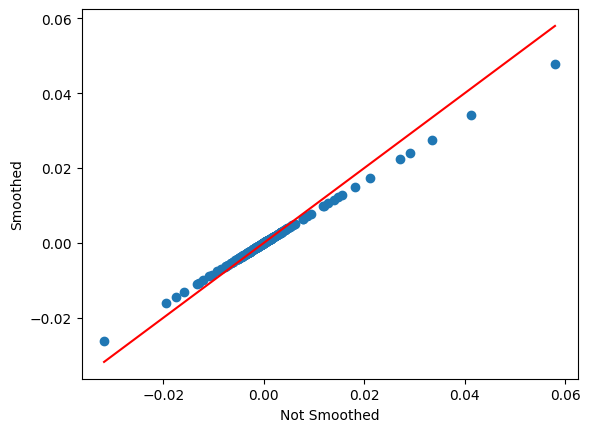

In [156]:
nz_ind = not_smooth_normed_feature_by_feature_attribution[:, N].nonzero()
not_smooth_normed_feature_by_feature_attribution[nz_ind, N], normed_feature_by_feature_attribution[nz_ind, N]
# Plot both, one as x and one as y
import matplotlib.pyplot as plt
plt.scatter(not_smooth_normed_feature_by_feature_attribution[nz_ind, N].detach().cpu(), normed_feature_by_feature_attribution[nz_ind, N].detach().cpu())
# Draw a diagonal thin linear between the min and max of both
min_val = not_smooth_normed_feature_by_feature_attribution[nz_ind, N].min().item()
max_val = not_smooth_normed_feature_by_feature_attribution[nz_ind, N].max().item()
plt.plot([min_val, max_val], [min_val, max_val], color='red')
plt.xlabel("Not Smoothed")
plt.ylabel("Smoothed")
plt.show()

In [126]:
normed = averaged_feature_by_feature_attribution / averaged_feature_by_feature_attribution.abs().sum(dim=0)
normed.abs().sum(dim=1), normed.shape, normed.abs()[:, 0].sum()

(tensor([6.7974, 1.0676, 2.3563,  ..., 2.2825, 0.9650, 0.0000], device='cuda:0',
        grad_fn=<SumBackward1>),
 torch.Size([6144, 6107]),
 tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>))

In [107]:
optimizer.zero_grad()
entropy_loss.backward()
torch.nn.utils.clip_grad_norm_([transcoder.decoder.weight, transcoder.encoder.weight, sae_final.encoder.weight], max_norm=1.0)
transcoder.decoder.weight.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [102]:
entropy_loss

tensor(3.9295, device='cuda:0', grad_fn=<MeanBackward0>)

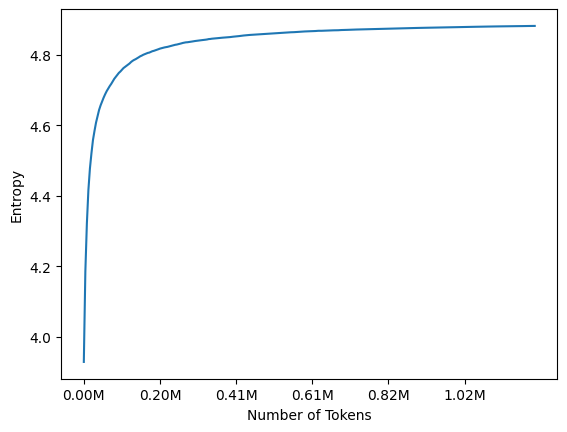

In [97]:
# Plot entropy_across_batches
import matplotlib.pyplot as plt
plt.plot(entropy_across_batches)
plt.xlabel("Number of Tokens")
plt.ylabel("Entropy")
# Set x indicies to be in increments of 10 to make it easier to read
# Each tick is 128*32 tokens
# Measure as M of tokens
n_ticks = 50
plt.xticks(range(0, len(entropy_across_batches), n_ticks), [f"{i*128*32/1e6:.2f}M" for i in range(0, len(entropy_across_batches), n_ticks)])
plt.show()

In [145]:
entropy_across_batches

[6.206844329833984]

In [141]:
# Now we want to divide feature_by_feature_attribution by each of the times it activated
alive_output_features = running_total_for_each_feature != 0

averaged_feature_by_feature_attribution = feature_by_feature_attribution[:, alive_output_features] / running_total_for_each_feature[alive_output_features].unsqueeze(0)
# Now we want to convert to a prob-dist and calculate entropy on it, ignoring dead features
normed_feature_by_feature_attribution = averaged_feature_by_feature_attribution / averaged_feature_by_feature_attribution.abs().sum(dim=0)

logged = normed_feature_by_feature_attribution.abs().log()
logged[logged.isinf()] = 0
entropy = -(normed_feature_by_feature_attribution.abs() * logged).sum(dim=0)
entropy.mean()

tensor(6.2069, device='cuda:0')

In [124]:
(running_total_for_each_feature[alive_output_features] == 0).any(), running_total_for_each_feature[alive_output_features].isnan().any(), feature_by_feature_attribution.isnan().any(), normed_feature_by_feature_attribution.isnan().any(), entropy.isnan().any(), averaged_feature_by_feature_attribution.isnan().any(), (averaged_feature_by_feature_attribution == 0).any()

(tensor(False, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(True, device='cuda:0'))

In [110]:
logged[logged.isnan()], logged.isnan().nonzero()
normed_feature_by_feature_attribution.abs()[0, 23]

tensor(nan, device='cuda:0')

In [93]:
torch.log(p1)

tensor([    -inf,     -inf,     -inf,  ..., -10.5742,     -inf,     -inf],
       device='cuda:0')

In [79]:
for N in range(10):
    assert (normed_feature_by_feature_attribution[:, N] == feature_by_feature_attribution[:, N] / running_total_for_each_feature[N]).all()

In [10]:
output_acts[output_indices==0]
input_acts[output_indices==0]
(output_indices==0).sum(-1) != 0, input_acts.shape

(tensor([False, False, False,  ..., False, False, False], device='cuda:0'),
 torch.Size([4128, 30]))

In [11]:
((output_indices==0).sum(-1) != 0).nonzero()

tensor([[2369],
        [3193],
        [3194],
        [3204],
        [3207],
        [3798]], device='cuda:0')

In [39]:
current_output_feature = 0
num_input_features = input_features.shape[-1]
num_output_features = output_features.shape[-1]
feature_by_feature_attribution = torch.zeros(num_input_features, num_output_features).to(device)
# features_set_yet = torch.zeros(num_output_features, dtype=torch.bool)
iteration = 1

for current_output_feature in range(num_output_features):
    # Get the batch indices where the output feature is non-zero
    nz_batch_indices = (output_indices==current_output_feature).sum(-1).nonzero()[:, 0]
    output_virtual_weights = virtual_weights[:, current_output_feature]

    # Index into the virtual weights & input indices ie find the inputs that activated the output feature
    nz_input_ind = input_indices[nz_batch_indices]
    batched_virtual_weights = output_virtual_weights[nz_input_ind].to(device)
    nz_input_acts = input_acts[nz_batch_indices]

    # Calculate the attribution ie act*gradient
    current_output_attribution = nz_input_acts * batched_virtual_weights 

    # Set the feature by feature attribution (average w/ existing attributions)    
    averaged_current_output_attribution = current_output_attribution.mean(dim=0)
    tmp_feature_list = torch.zeros(num_input_features).to(device)
    # Assign the averaged attributions to the correct input features
    # tmp_feature_list[nz_input_ind] = averaged_current_output_attribution

    feature_by_feature_attribution[nz_input_ind, current_output_feature] += averaged_current_output_attribution

# Normalize the attributions (by abs value cause negative gradients)
# total_abs_value = current_output_attribution.abs().sum(dim=-1)
# normed_current_output_attribution = current_output_attribution / total_abs_value[:, None]


In [106]:
normed_current_output_attribution.abs().sum(dim=-1), normed_current_output_attribution.mean(dim=0).abs().sum(dim=-1)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
 tensor(0.7414, device='cuda:0'))

In [110]:
normed_current_output_attribution.abs().mean(dim=0).abs().sum()

tensor(1., device='cuda:0')

In [105]:
normed_current_output_attribution.shape

torch.Size([6, 30])

In [96]:
total_abs_value = current_output_attribution.abs().sum(dim=-1)
# Normalize: 
normed_current_output_attribution = current_output_attribution / total_abs_value[:, None]

AssertionError: 

In [100]:
normed_current_output_attribution

tensor([[-3.6227e-02, -2.6679e-03, -2.5494e-02, -1.2283e-03,  1.7044e-01,
         -4.9746e-02, -1.8890e-02, -6.3689e-02, -3.3854e-02,  1.7237e-01,
         -6.0978e-03,  2.1763e-02, -4.3416e-02,  7.5457e-02,  2.9024e-02,
         -6.1067e-03,  5.2058e-03, -3.8862e-02, -6.2616e-03, -1.0429e-02,
         -2.1213e-02, -3.2377e-02, -2.1631e-02,  1.1801e-02, -4.8583e-02,
          7.9568e-03,  3.5445e-03, -9.7144e-03, -1.8767e-02, -7.1831e-03],
        [-1.3719e-02,  2.5239e-03,  4.5559e-01,  6.0995e-03,  1.5561e-01,
         -4.0269e-02, -1.2523e-02, -4.5647e-02,  6.8993e-03, -1.0656e-02,
         -5.3215e-02, -1.6520e-02, -9.7398e-03,  2.4028e-03, -1.1964e-02,
         -5.8181e-03, -1.9840e-02, -1.1012e-03, -1.8136e-02,  2.4025e-03,
          2.2144e-04,  1.3957e-02, -2.2930e-02,  9.7942e-03, -1.6925e-02,
         -5.8936e-03, -6.2075e-03,  1.3838e-02, -1.9537e-02,  2.1156e-05],
        [-9.3610e-02,  2.0581e-03,  2.8441e-03, -1.7609e-02,  3.2889e-01,
          2.9626e-03, -5.8919e-03, -

In [97]:
normed_current_output_attribution.norm(dim=-1)

tensor([0.2906, 0.4918, 0.3760, 0.3835, 0.3477, 0.5571], device='cuda:0')

In [95]:
current_output_attribution[0].abs().sum()

tensor(4.4699, device='cuda:0')

In [7]:
unique_input_indices = torch.unique(input_indices)
input_features[:, unique_input_indices].isnan().any()
unique_output_indices = torch.unique(output_indices)

# output_features.shape, unique_output_indices.shape
# virtual_weights[unique_input_indices][:, unique_output_indices]

In [9]:
virtual_weights.shape, unique_output_indices.max()

(torch.Size([6144, 6143]), tensor(6143, device='cuda:0'))

In [12]:
import torch
from einops import rearrange, einsum


def sparse_attribution(input_features, virtual_weights, input_indices, output_indices):
    # Find unique input and output indices across the batch
    unique_input_indices = torch.unique(input_indices)
    unique_output_indices = torch.unique(output_indices)

    # combine batch and sequence dimensions
    input_features = rearrange(input_features, 'b s i -> (b s) i')

    # Extract relevant slices of input_features and virtual_weights
    sparse_input_features = input_features[:, unique_input_indices]
    sparse_virtual_weights = virtual_weights[unique_input_indices][:, unique_output_indices]

    # Perform the sparse matrix multiplication
    sparse_attribution = torch.einsum('bi,ij->bij', sparse_input_features, sparse_virtual_weights)

    # Create a tensor to hold the full attribution
    full_attribution = torch.zeros(input_features.shape[0], input_features.shape[1], virtual_weights.shape[1], device=input_features.device)

    # Place the sparse attribution results in the correct positions in the full attribution tensor
    full_attribution[:, unique_input_indices[:, None], unique_output_indices] = sparse_attribution

    return full_attribution

# Usage
# Assuming input_features, virtual_weights, input_indices, and output_indices are defined
# attribution = sparse_attribution(input_features, virtual_weights, input_indices, output_indices)

unique_input_indices = torch.unique(input_indices)
unique_output_indices = torch.unique(output_indices)

# Extract relevant slices of input_features and virtual_weights
sparse_input_features = input_features[:, unique_input_indices]
sparse_virtual_weights = virtual_weights[unique_input_indices][:, unique_output_indices]

# Perform the sparse matrix multiplication
spar_attr = torch.einsum('bi,ij->bij', sparse_input_features, sparse_virtual_weights)

# # Create a tensor to hold the full attribution
# full_attribution = torch.zeros(input_features.shape[0], input_features.shape[1], virtual_weights.shape[1], device=input_features.device)

# # Place the sparse attribution results in the correct positions in the full attribution tensor
# full_attribution[:, unique_input_indices[:, None], unique_output_indices] = spar_attr


OutOfMemoryError: CUDA out of memory. Tried to allocate 795.99 GiB. GPU 0 has a total capacity of 15.73 GiB of which 14.37 GiB is free. Process 2007258 has 1.35 GiB memory in use. Of the allocated memory 1.07 GiB is allocated by PyTorch, and 93.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
input_features.shape, unique_input_indices.shape, unique_output_indices.shape

(torch.Size([8256, 6144]), torch.Size([4292]), torch.Size([6030]))

In [6]:
sparse_input_features.shape, sparse_virtual_weights.shape

(torch.Size([8256, 4292]), torch.Size([4292, 6030]))

In [4]:
print("input_features shape:", input_features.shape)
unique_input_indices = torch.unique(input_indices)
print("unique_input_indices shape:", unique_input_indices.shape)
print("Max value in unique_input_indices:", unique_input_indices.max().item())
print("Min value in unique_input_indices:", unique_input_indices.min().item())

input_features shape: torch.Size([64, 129, 6144])
unique_input_indices shape: torch.Size([4292])
Max value in unique_input_indices: 6142
Min value in unique_input_indices: 0


In [11]:

unique_input_indices = input_indices.unique()
unique_output_indices = output_indices.unique()

# # Extract relevant slices of input_features and virtual_weights
sparse_input_features = input_features[:, unique_input_indices]
sparse_virtual_weights = virtual_weights[unique_input_indices][:, unique_output_indices]
# sparse_input_features

In [7]:
uniq = input_indices.unique().cpu().numpy()
uniq

(4292,)

In [8]:
input_features.index([0,1], dim=-1)

AttributeError: 'Tensor' object has no attribute 'index'

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [38]:
from einops import rearrange, einsum
input_features = rearrange(input_features, 'b s f -> (b s) f')
attribution = einsum(input_features, virtual_weights, "b f1, f1 f2 -> b f1 f2")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1160.81 GiB. GPU 0 has a total capacity of 15.73 GiB of which 13.95 GiB is free. Process 1969018 has 1.78 GiB memory in use. Of the allocated memory 1.55 GiB is allocated by PyTorch, and 37.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
attribution = torch.dot(input_features, virtual_weights)
# RuntimeError: self must be a matrix
# attribution = input_features * virtual_weights

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [32]:
input_features.shape, virtual_weights.shape
attribution = torch.einsum('bi,ij->bij', input_features, virtual_weights)


(torch.Size([8256, 6144]), torch.Size([6144, 6143]))

In [5]:
attribution = rearrange(attribution, 'b s f -> (b s) f')

In [15]:
attribution.shape

torch.Size([64, 129, 6143])

In [6]:
output_indices = rearrange(output_indices, 'b s f -> (b s) f')

In [13]:
output_indices[:, 0].shape

torch.Size([64, 30])

In [8]:
with torch.no_grad():
    attribution = input_features @ virtual_weights

In [9]:
input_features.shape, virtual_weights.shape

(torch.Size([64, 129, 6144]), torch.Size([6144, 6143]))

In [10]:
# We want to calculate attribution = act*gradient

# I believe this is equivalent to the weights of the activations (ignore biases)
# It'd be good to actually verify this is the case



with torch.no_grad():
    tr_dec = transcoder.decoder.weight
    #TODO: we removed the last weight to help w/ knowing .T and shape. 
    final_enc = sae_final.encoder.weight[:-1]
    virtual_weights = tr_dec.T @ final_enc.T

    act_res_mid = act_res_mid.to(device)
    input_features, input_acts, input_indices = transcoder.encode(act_res_mid, return_topk=True)
    mlp_out_hat = transcoder.decoder(input_features)

    output_features, output_acts, output_indices = sae_final.encode(mlp_out_hat + act_res_mid, return_topk=True)

    # For efficient gradient calculation, we can get the nonzero_indices of both input & output feature

    # W_input = transcoder.decoder.weight[input_indices]    

In [12]:
transcoder.decoder.weight.shape, input_indices.shape

(torch.Size([768, 6144]), torch.Size([64, 129, 30]))

In [ ]:
# def encode(self, x: torch.Tensor, return_topk: bool = False):
#     post_relu_feat_acts_BF = nn.functional.relu(self.encoder(x - self.b_dec))
#     post_topk = post_relu_feat_acts_BF.topk(self.k, sorted=False, dim=-1)

#     # We can't split immediately due to nnsight
#     tops_acts_BK = post_topk.values
#     top_indices_BK = post_topk.indices

#     buffer_BF = torch.zeros_like(post_relu_feat_acts_BF)
#     encoded_acts_BF = buffer_BF.scatter_(dim=-1, index=top_indices_BK, src=tops_acts_BK)

#     if return_topk:
#         return encoded_acts_BF, tops_acts_BK, top_indices_BK
#     else:
#         return encoded_acts_BF

# def decode(self, x: torch.Tensor) -> torch.Tensor:
#     return self.decoder(x) + self.b_dec